## Instance Segmentation Using Habitat-Sim and Mask-R-CNN

author: Michael Piseno (mpiseno@gatech.edu)

This notebook will demonstrate how to set up an efficient datapipline for the purpose of instance segmentation using PyTorch, Mask-R-CNN, and Habitat-Sim as a data generator.

Other resources:
* [Mask-R-CNN paper](https://arxiv.org/pdf/1703.06870.pdf)
* [PyTorch instance segmentation tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

In [1]:
%load_ext autoreload
%autoreload 2

import os
import time
import math
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.data import Dataset

from habitat_sim.utils.data.dataextractor import ImageExtractor

### Data preparation and proprocessing

Below we will define the data extraction and preprocessing steps. Habitat-Sim's image data extraction API will be used to gather images from within the simulator for use inside a PyTorch Dataset subclass, which is subsequently fed into a PyTorch dataloader. Also, we will define a function to filter our semantic mask output from the extractor to hide instances that we don't want. For example, if the semantic output has instances of wall, chair, table, pillow, and background, but we only want to do instance segmentation on chairs and tables, we will simply set the semantic mask pixel values for wall and pillow to be the same as background.

In [2]:
try:
    extractor.close()
except:
    pass

 
#scene = "/private/home/mpiseno/Documents/Habitat/data/scene1/17DRP5sb8fy.glb" # mp3d
scene = "/private/home/mpiseno/Documents/Habitat/sorted_faces/18_scenes/apartment_1/mesh.ply" # Replica
#scene_dir = "/private/home/mpiseno/Documents/Habitat/data/" # Replace with your scene directory
extractor = ImageExtractor(scene, output=["rgb", "depth", "semantic"], shuffle=False)

I0220 11:18:11.999010 71073 simulator.py:131] Loaded navmesh /private/home/mpiseno/Documents/Habitat/sorted_faces/18_scenes/apartment_1/habitat/mesh_semantic.navmesh


sim_cfg.physics_config_file = ./data/default.phys_scene_config.json
sim_cfg.physics_config_file = ./data/default.phys_scene_config.json


In [91]:
# Get the instance ids associated with the labels we specified and make a set from them
from examples.instance_segmentation.common import create_mask_filter, area_filter

# labels = ['bed', 'cushion', 'table', 'chair', 'sofa', 'tv_monitor',
#           'floor', 'door', 'cabinet', 'counter', 'stool', 'blinds']

labels = extractor.get_semantic_class_names()

mask_filter = create_mask_filter(labels, extractor)

In [92]:
def collate_fn(batch):
    return tuple(zip(*batch))   
    
class HabitatDataset(Dataset):
    def __init__(self, extractor, transform=None):
        self.extractor = extractor
        self.transform = transform
        self.instance_id_to_name = extractor.instance_id_to_name
        
        # key 0 in the extractor's instance_id_to_name map is 'wall',
        # but based on our mask filter function, we want key 0 to map to background,
        # so we'll manually change it here
        self.instance_id_to_name[0] = 'background'
        
        # Create a mapping from class name to semantic ID
        #classes = np.unique([val for val in self.instance_id_to_name.values()])
        classes = ['background'] + labels
        self.name_to_sem_id = {
            name: id_val for id_val, name in enumerate(classes)
        }
        # And create the reverse mapping for convenience
        self.sem_id_to_name = {
            id_val: name for name, id_val in self.name_to_sem_id.items()
        }
        
    def __len__(self):
        return len(self.extractor)
    
    def __getitem__(self, idx):
        sample = self.extractor[idx]
        img, mask = sample["rgb"][:, :, :3], sample["semantic"]
        mask = mask_filter(mask)
        H, W = mask.shape
        
        instance_ids = np.unique(mask)
        #instance_ids = instance_ids[1:] # We don't care about background
        
        # get bounding box coordinates, mask, and label for each instance_id
        masks = []
        labels = []
        boxes = []
        areas = []
        num_instances = len(instance_ids)
        
        # There are much more efficient ways to create the data involving caching and
        # preprocessing but efficiency is not the focus of this example
        for i in range(num_instances):
            cur_mask = mask == instance_ids[i]
            pos = np.where(cur_mask)
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            
            # Avoid zero area boxes
            if xmin == xmax:
                xmin = max(0, xmin - 1)
                xmax = min(W, xmax + 1)
            if ymin == ymax:
                ymin = max(0, ymin - 1)
                ymax = min(H, ymax + 1)
            
            box = (xmin, ymin, xmax, ymax)
            if area_filter(cur_mask, box, H, W):
                boxes.append(list(box))
                masks.append(cur_mask)
                name = self.instance_id_to_name[instance_ids[i]]
                labels.append(self.name_to_sem_id[name])
                areas.append((ymax - ymin) * (xmax - xmin))

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_instances,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = areas
        target["iscrowd"] = iscrowd
        
        if self.transform:
            img = self.transform(img)
        
        return img, target

First we instantiate an ImageExtractor from Habitat-Sim. This requires that we previde either a the filepath to a scene or a filepath to a diretory which contains several scene files. Optionally, we can specify the type of output we would like from the extractor. The default is just RGBA images.For details on the ImageExtractor, refer to the "Image-Data_Extraction-API" notebook.

Example
```python
scene_filepath = "./data/scene1/skokloster-castle.glb"
extractor = ImageExtractor(scene_filepath, output=["rgb", "semantic"])
```

We then create a custom class that subclasses PyTorch's dataset and override the __len__ and __getitem__ methods. Mask-R-CNN requires that we provide the image, bounding boxes, semantic masks, and class labels for each example, so we have implemented functionality for that in the __getitem__ method. The area and iscrowd keys are required for the evaluation metrics we use in this notebook.

#### Setting up the datasets and dataloaders

In [93]:
# Specify which transforms to apply to the data in preprocessing
transform = T.Compose([
    T.ToTensor()
])

dataset_train = HabitatDataset(extractor, transform=transform)
dataset_test = HabitatDataset(extractor, transform=transform)

dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=2, shuffle=False,
                                          collate_fn=collate_fn)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=2, shuffle=False,
                                          collate_fn=collate_fn)

#### Visualize the data

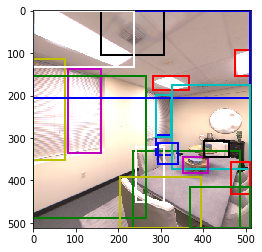

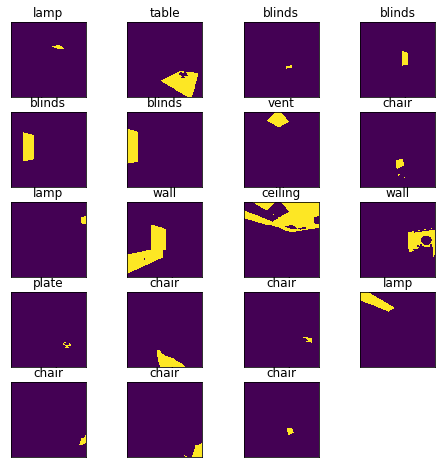

In [94]:
import matplotlib.patches as patches


def show_data(data_idx, show_masks=False):
    img, target = dataset_train[data_idx]
    img = img.permute(1, 2, 0).numpy()
    masks = target['masks'].numpy()
    boxes = target['boxes'].numpy()
    labels = target['labels']
    areas = target['area']
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    cmap = {0: 'r', 1: 'g', 2: 'b', 3: 'c', 4: 'm', 5: 'y', 6: 'k', 7: 'w'}
    for i, box in enumerate(boxes):
        h, w = box[3] - box[1], box[2] - box[0]
        rect = patches.Rectangle((box[0], box[1]) , w, h, linewidth=2,
                                 edgecolor=cmap[i % len(cmap)], facecolor='none')
        ax.add_patch(rect)

    
    if show_masks:
        plt.show()
        fig=plt.figure(figsize=(8, 8))
        columns = 4
        rows = math.ceil(len(target['masks']) / columns)
        for i in range(1, columns * rows + 1):
            if i > len(target['masks']):
                break
            mask = masks[i - 1]
            ax = fig.add_subplot(rows, columns, i)
            sem_id = int(labels[i - 1].numpy())
            ax.title.set_text(dataset_train.sem_id_to_name[sem_id])
            plt.xticks([])
            plt.yticks([])
            plt.imshow(mask)
        
show_data(15, show_masks=True)


### Model and Training Setup

In [97]:
from torch.utils.tensorboard import SummaryWriter

# Credit: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model


num_epochs = 160000
num_classes = len(labels) + 1 # Number of labels we care about + background
model_state_path = "examples/instance_segmentation/runs/maskrcnn-example-state.pt"
load_state = False

model = build_model(num_classes)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.002, momentum=0.9, weight_decay=0.0001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=4)
writer = SummaryWriter("examples/instance_segmentation/runs/")


### Training and Evaluation

In [98]:
from examples.instance_segmentation.engine import train_one_epoch, load_model_state, save_model_state, evaluate

epoch = 1
if load_state:
    params = {'lr': 0.002}
    epoch = load_model_state(model, optimizer, model_state_path, params)
    
optimizer.lr = 0.002

while epoch < num_epochs:
    # We have to explicitly set the extractor mode because there can only be one instance of an extractor at a time,
    # so the dataset_train and dataset_test must share the same extractor
    extractor.set_mode('train')
    train_one_epoch(model, optimizer, dataloader_train, device, epoch, print_freq=10, 
                    writer=writer, grad_clip=0, lr_scheduler=lr_scheduler)
    
    if epoch % 50 == 0:
        save_model_state(model, optimizer, epoch, model_state_path)
        extractor.set_mode('test')
        evaluate(model, dataloader_test, device=device)
    
    epoch += 1

Epoch: [1]  [ 0/16]  eta: 0:00:18  lr: 0.002000  loss: 6.6700 (6.6700)  loss_classifier: 3.3848 (3.3848)  loss_box_reg: 0.3512 (0.3512)  loss_mask: 1.3308 (1.3308)  loss_objectness: 1.5111 (1.5111)  loss_rpn_box_reg: 0.0921 (0.0921)  time: 1.1601  data: 0.7876  max mem: 2874
Epoch: [1]  [10/16]  eta: 0:00:09  lr: 0.002000  loss: 2.8465 (3.1386)  loss_classifier: 1.3133 (1.4197)  loss_box_reg: 0.5064 (0.4995)  loss_mask: 0.7939 (0.8238)  loss_objectness: 0.1307 (0.2969)  loss_rpn_box_reg: 0.0934 (0.0986)  time: 1.6487  data: 1.3508  max mem: 3659
Epoch: [1]  [15/16]  eta: 0:00:01  lr: 0.002000  loss: 2.7703 (2.8819)  loss_classifier: 1.1269 (1.2769)  loss_box_reg: 0.5064 (0.4964)  loss_mask: 0.6904 (0.7776)  loss_objectness: 0.1110 (0.2345)  loss_rpn_box_reg: 0.0934 (0.0964)  time: 1.7033  data: 1.4151  max mem: 3662
Epoch: [1] Total time: 0:00:27 (1.7035 s / it)
Epoch: [2]  [ 0/16]  eta: 0:00:16  lr: 0.002000  loss: 1.5351 (1.5351)  loss_classifier: 0.4523 (0.4523)  loss_box_reg: 0.287

Epoch: [10]  [15/16]  eta: 0:00:01  lr: 0.002000  loss: 0.6168 (0.7216)  loss_classifier: 0.1766 (0.2310)  loss_box_reg: 0.2062 (0.2106)  loss_mask: 0.1902 (0.2133)  loss_objectness: 0.0060 (0.0056)  loss_rpn_box_reg: 0.0538 (0.0610)  time: 1.6953  data: 1.4094  max mem: 3662
Epoch: [10] Total time: 0:00:27 (1.6955 s / it)
Epoch: [11]  [ 0/16]  eta: 0:00:16  lr: 0.002000  loss: 0.4010 (0.4010)  loss_classifier: 0.1125 (0.1125)  loss_box_reg: 0.1209 (0.1209)  loss_mask: 0.1080 (0.1080)  loss_objectness: 0.0024 (0.0024)  loss_rpn_box_reg: 0.0572 (0.0572)  time: 1.0537  data: 0.7801  max mem: 3662
Epoch: [11]  [10/16]  eta: 0:00:09  lr: 0.002000  loss: 0.5654 (0.6560)  loss_classifier: 0.1681 (0.2136)  loss_box_reg: 0.1682 (0.1867)  loss_mask: 0.1861 (0.1849)  loss_objectness: 0.0053 (0.0070)  loss_rpn_box_reg: 0.0597 (0.0639)  time: 1.6416  data: 1.3488  max mem: 3662
Epoch: [11]  [15/16]  eta: 0:00:01  lr: 0.002000  loss: 0.5668 (0.6766)  loss_classifier: 0.1720 (0.2256)  loss_box_reg: 

Epoch: [20]  [ 0/16]  eta: 0:00:17  lr: 0.002000  loss: 0.2827 (0.2827)  loss_classifier: 0.0703 (0.0703)  loss_box_reg: 0.0716 (0.0716)  loss_mask: 0.0690 (0.0690)  loss_objectness: 0.0020 (0.0020)  loss_rpn_box_reg: 0.0699 (0.0699)  time: 1.0655  data: 0.7823  max mem: 3662
Epoch: [20]  [10/16]  eta: 0:00:10  lr: 0.002000  loss: 0.3388 (0.4051)  loss_classifier: 0.0768 (0.1099)  loss_box_reg: 0.0855 (0.1059)  loss_mask: 0.1361 (0.1317)  loss_objectness: 0.0020 (0.0029)  loss_rpn_box_reg: 0.0423 (0.0546)  time: 1.7397  data: 1.4450  max mem: 3662
Epoch: [20]  [15/16]  eta: 0:00:01  lr: 0.002000  loss: 0.3735 (0.4292)  loss_classifier: 0.0946 (0.1178)  loss_box_reg: 0.0855 (0.1077)  loss_mask: 0.1408 (0.1449)  loss_objectness: 0.0020 (0.0029)  loss_rpn_box_reg: 0.0423 (0.0559)  time: 1.7677  data: 1.4804  max mem: 3662
Epoch: [20] Total time: 0:00:28 (1.7679 s / it)
Epoch: [21]  [ 0/16]  eta: 0:00:16  lr: 0.002000  loss: 0.2671 (0.2671)  loss_classifier: 0.0497 (0.0497)  loss_box_reg: 

Epoch: [29]  [15/16]  eta: 0:00:01  lr: 0.002000  loss: 0.3136 (0.3223)  loss_classifier: 0.0675 (0.0793)  loss_box_reg: 0.0642 (0.0686)  loss_mask: 0.1203 (0.1235)  loss_objectness: 0.0022 (0.0044)  loss_rpn_box_reg: 0.0422 (0.0465)  time: 1.6977  data: 1.4119  max mem: 3662
Epoch: [29] Total time: 0:00:27 (1.6978 s / it)
Epoch: [30]  [ 0/16]  eta: 0:00:16  lr: 0.002000  loss: 0.1733 (0.1733)  loss_classifier: 0.0272 (0.0272)  loss_box_reg: 0.0334 (0.0334)  loss_mask: 0.0598 (0.0598)  loss_objectness: 0.0014 (0.0014)  loss_rpn_box_reg: 0.0514 (0.0514)  time: 1.0536  data: 0.7837  max mem: 3662
Epoch: [30]  [10/16]  eta: 0:00:09  lr: 0.002000  loss: 0.2983 (0.3027)  loss_classifier: 0.0637 (0.0644)  loss_box_reg: 0.0626 (0.0772)  loss_mask: 0.1071 (0.1099)  loss_objectness: 0.0035 (0.0053)  loss_rpn_box_reg: 0.0453 (0.0458)  time: 1.6400  data: 1.3466  max mem: 3662
Epoch: [30]  [15/16]  eta: 0:00:01  lr: 0.002000  loss: 0.2983 (0.3156)  loss_classifier: 0.0637 (0.0646)  loss_box_reg: 

Epoch: [39]  [ 0/16]  eta: 0:00:17  lr: 0.002000  loss: 0.1654 (0.1654)  loss_classifier: 0.0422 (0.0422)  loss_box_reg: 0.0232 (0.0232)  loss_mask: 0.0553 (0.0553)  loss_objectness: 0.0020 (0.0020)  loss_rpn_box_reg: 0.0427 (0.0427)  time: 1.0627  data: 0.7833  max mem: 3662
Epoch: [39]  [10/16]  eta: 0:00:09  lr: 0.002000  loss: 0.2305 (0.2576)  loss_classifier: 0.0527 (0.0684)  loss_box_reg: 0.0390 (0.0470)  loss_mask: 0.1022 (0.0994)  loss_objectness: 0.0020 (0.0034)  loss_rpn_box_reg: 0.0357 (0.0394)  time: 1.6441  data: 1.3497  max mem: 3662
Epoch: [39]  [15/16]  eta: 0:00:01  lr: 0.002000  loss: 0.2673 (0.2671)  loss_classifier: 0.0639 (0.0680)  loss_box_reg: 0.0401 (0.0492)  loss_mask: 0.1092 (0.1066)  loss_objectness: 0.0020 (0.0038)  loss_rpn_box_reg: 0.0336 (0.0396)  time: 1.6980  data: 1.4114  max mem: 3662
Epoch: [39] Total time: 0:00:27 (1.6982 s / it)
Epoch: [40]  [ 0/16]  eta: 0:00:16  lr: 0.002000  loss: 0.1763 (0.1763)  loss_classifier: 0.0400 (0.0400)  loss_box_reg: 

Epoch: [48]  [15/16]  eta: 0:00:01  lr: 0.002000  loss: 0.2190 (0.2275)  loss_classifier: 0.0446 (0.0486)  loss_box_reg: 0.0311 (0.0356)  loss_mask: 0.0937 (0.0988)  loss_objectness: 0.0021 (0.0030)  loss_rpn_box_reg: 0.0363 (0.0416)  time: 1.6970  data: 1.4110  max mem: 3662
Epoch: [48] Total time: 0:00:27 (1.6972 s / it)
Epoch: [49]  [ 0/16]  eta: 0:00:16  lr: 0.002000  loss: 0.1613 (0.1613)  loss_classifier: 0.0277 (0.0277)  loss_box_reg: 0.0266 (0.0266)  loss_mask: 0.0525 (0.0525)  loss_objectness: 0.0011 (0.0011)  loss_rpn_box_reg: 0.0534 (0.0534)  time: 1.0530  data: 0.7808  max mem: 3662
Epoch: [49]  [10/16]  eta: 0:00:09  lr: 0.002000  loss: 0.2184 (0.2234)  loss_classifier: 0.0363 (0.0459)  loss_box_reg: 0.0314 (0.0372)  loss_mask: 0.0886 (0.0921)  loss_objectness: 0.0025 (0.0037)  loss_rpn_box_reg: 0.0399 (0.0446)  time: 1.6405  data: 1.3475  max mem: 3662
Epoch: [49]  [15/16]  eta: 0:00:01  lr: 0.002000  loss: 0.2184 (0.2359)  loss_classifier: 0.0363 (0.0481)  loss_box_reg: 

Epoch: [55]  [10/16]  eta: 0:00:09  lr: 0.000200  loss: 0.1526 (0.1591)  loss_classifier: 0.0286 (0.0352)  loss_box_reg: 0.0146 (0.0162)  loss_mask: 0.0899 (0.0864)  loss_objectness: 0.0016 (0.0022)  loss_rpn_box_reg: 0.0179 (0.0191)  time: 1.6434  data: 1.3491  max mem: 3662
Epoch: [55]  [15/16]  eta: 0:00:01  lr: 0.000200  loss: 0.1548 (0.1707)  loss_classifier: 0.0344 (0.0367)  loss_box_reg: 0.0186 (0.0183)  loss_mask: 0.0907 (0.0945)  loss_objectness: 0.0019 (0.0025)  loss_rpn_box_reg: 0.0179 (0.0186)  time: 1.6964  data: 1.4093  max mem: 3662
Epoch: [55] Total time: 0:00:27 (1.6966 s / it)
Epoch: [56]  [ 0/16]  eta: 0:00:16  lr: 0.000200  loss: 0.1013 (0.1013)  loss_classifier: 0.0229 (0.0229)  loss_box_reg: 0.0087 (0.0087)  loss_mask: 0.0491 (0.0491)  loss_objectness: 0.0009 (0.0009)  loss_rpn_box_reg: 0.0197 (0.0197)  time: 1.0510  data: 0.7761  max mem: 3662
Epoch: [56]  [10/16]  eta: 0:00:09  lr: 0.000200  loss: 0.1516 (0.1602)  loss_classifier: 0.0261 (0.0339)  loss_box_reg: 

Epoch: [65]  [ 0/16]  eta: 0:00:17  lr: 0.000200  loss: 0.0828 (0.0828)  loss_classifier: 0.0139 (0.0139)  loss_box_reg: 0.0075 (0.0075)  loss_mask: 0.0484 (0.0484)  loss_objectness: 0.0014 (0.0014)  loss_rpn_box_reg: 0.0117 (0.0117)  time: 1.0681  data: 0.7881  max mem: 3662
Epoch: [65]  [10/16]  eta: 0:00:09  lr: 0.000200  loss: 0.1511 (0.1534)  loss_classifier: 0.0289 (0.0329)  loss_box_reg: 0.0157 (0.0173)  loss_mask: 0.0889 (0.0875)  loss_objectness: 0.0014 (0.0028)  loss_rpn_box_reg: 0.0117 (0.0129)  time: 1.6452  data: 1.3496  max mem: 3662
Epoch: [65]  [15/16]  eta: 0:00:01  lr: 0.000200  loss: 0.1566 (0.1666)  loss_classifier: 0.0289 (0.0340)  loss_box_reg: 0.0187 (0.0190)  loss_mask: 0.0918 (0.0974)  loss_objectness: 0.0014 (0.0033)  loss_rpn_box_reg: 0.0117 (0.0129)  time: 1.6978  data: 1.4110  max mem: 3662
Epoch: [65] Total time: 0:00:27 (1.6980 s / it)
Epoch: [66]  [ 0/16]  eta: 0:00:16  lr: 0.000200  loss: 0.0871 (0.0871)  loss_classifier: 0.0156 (0.0156)  loss_box_reg: 

Epoch: [74]  [15/16]  eta: 0:00:01  lr: 0.000200  loss: 0.1483 (0.1561)  loss_classifier: 0.0312 (0.0322)  loss_box_reg: 0.0174 (0.0166)  loss_mask: 0.0905 (0.0930)  loss_objectness: 0.0015 (0.0026)  loss_rpn_box_reg: 0.0105 (0.0116)  time: 1.6929  data: 1.4092  max mem: 3662
Epoch: [74] Total time: 0:00:27 (1.6931 s / it)
Epoch: [75]  [ 0/16]  eta: 0:00:16  lr: 0.000200  loss: 0.0836 (0.0836)  loss_classifier: 0.0171 (0.0171)  loss_box_reg: 0.0077 (0.0077)  loss_mask: 0.0477 (0.0477)  loss_objectness: 0.0009 (0.0009)  loss_rpn_box_reg: 0.0102 (0.0102)  time: 1.0527  data: 0.7774  max mem: 3662
Epoch: [75]  [10/16]  eta: 0:00:09  lr: 0.000200  loss: 0.1451 (0.1479)  loss_classifier: 0.0275 (0.0314)  loss_box_reg: 0.0150 (0.0160)  loss_mask: 0.0880 (0.0875)  loss_objectness: 0.0010 (0.0013)  loss_rpn_box_reg: 0.0102 (0.0116)  time: 1.6442  data: 1.3484  max mem: 3662
Epoch: [75]  [15/16]  eta: 0:00:01  lr: 0.000200  loss: 0.1507 (0.1566)  loss_classifier: 0.0307 (0.0328)  loss_box_reg: 

Epoch: [84]  [ 0/16]  eta: 0:00:17  lr: 0.000020  loss: 0.0761 (0.0761)  loss_classifier: 0.0109 (0.0109)  loss_box_reg: 0.0076 (0.0076)  loss_mask: 0.0471 (0.0471)  loss_objectness: 0.0009 (0.0009)  loss_rpn_box_reg: 0.0095 (0.0095)  time: 1.0645  data: 0.7879  max mem: 3662
Epoch: [84]  [10/16]  eta: 0:00:09  lr: 0.000020  loss: 0.1401 (0.1428)  loss_classifier: 0.0254 (0.0294)  loss_box_reg: 0.0145 (0.0154)  loss_mask: 0.0865 (0.0855)  loss_objectness: 0.0013 (0.0015)  loss_rpn_box_reg: 0.0095 (0.0110)  time: 1.6642  data: 1.3715  max mem: 3662
Epoch: [84]  [15/16]  eta: 0:00:01  lr: 0.000020  loss: 0.1440 (0.1530)  loss_classifier: 0.0295 (0.0314)  loss_box_reg: 0.0145 (0.0164)  loss_mask: 0.0901 (0.0919)  loss_objectness: 0.0013 (0.0024)  loss_rpn_box_reg: 0.0095 (0.0109)  time: 1.7589  data: 1.4732  max mem: 3662
Epoch: [84] Total time: 0:00:28 (1.7591 s / it)
Epoch    83: reducing learning rate of group 0 to 2.0000e-06.
Epoch: [85]  [ 0/16]  eta: 0:00:16  lr: 0.000002  loss: 0.0

Epoch: [93]  [10/16]  eta: 0:00:09  lr: 0.000002  loss: 0.1428 (0.1462)  loss_classifier: 0.0274 (0.0297)  loss_box_reg: 0.0146 (0.0166)  loss_mask: 0.0865 (0.0872)  loss_objectness: 0.0016 (0.0018)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 1.6415  data: 1.3486  max mem: 3662
Epoch: [93]  [15/16]  eta: 0:00:01  lr: 0.000002  loss: 0.1461 (0.1564)  loss_classifier: 0.0299 (0.0309)  loss_box_reg: 0.0154 (0.0173)  loss_mask: 0.0916 (0.0946)  loss_objectness: 0.0016 (0.0028)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 1.7042  data: 1.4173  max mem: 3662
Epoch: [93] Total time: 0:00:27 (1.7044 s / it)
Epoch: [94]  [ 0/16]  eta: 0:00:17  lr: 0.000002  loss: 0.0767 (0.0767)  loss_classifier: 0.0115 (0.0115)  loss_box_reg: 0.0076 (0.0076)  loss_mask: 0.0471 (0.0471)  loss_objectness: 0.0010 (0.0010)  loss_rpn_box_reg: 0.0094 (0.0094)  time: 1.0887  data: 0.8079  max mem: 3662
Epoch: [94]  [10/16]  eta: 0:00:09  lr: 0.000002  loss: 0.1427 (0.1418)  loss_classifier: 0.0280 (0.0296)  loss_box_reg: 

Epoch: [101]  [ 0/16]  eta: 0:00:16  lr: 0.000000  loss: 0.0861 (0.0861)  loss_classifier: 0.0134 (0.0134)  loss_box_reg: 0.0076 (0.0076)  loss_mask: 0.0471 (0.0471)  loss_objectness: 0.0086 (0.0086)  loss_rpn_box_reg: 0.0094 (0.0094)  time: 1.0495  data: 0.7762  max mem: 3662
Epoch: [101]  [10/16]  eta: 0:00:09  lr: 0.000000  loss: 0.1377 (0.1412)  loss_classifier: 0.0219 (0.0283)  loss_box_reg: 0.0139 (0.0144)  loss_mask: 0.0865 (0.0847)  loss_objectness: 0.0018 (0.0028)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 1.6662  data: 1.3722  max mem: 3662
Epoch: [101]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.1468 (0.1510)  loss_classifier: 0.0279 (0.0301)  loss_box_reg: 0.0145 (0.0154)  loss_mask: 0.0898 (0.0920)  loss_objectness: 0.0013 (0.0026)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 1.7204  data: 1.4344  max mem: 3662
Epoch: [101] Total time: 0:00:27 (1.7206 s / it)
Epoch: [102]  [ 0/16]  eta: 0:00:16  lr: 0.000000  loss: 0.0755 (0.0755)  loss_classifier: 0.0108 (0.0108)  loss_box_

Epoch: [110]  [10/16]  eta: 0:00:10  lr: 0.000000  loss: 0.1402 (0.1464)  loss_classifier: 0.0272 (0.0316)  loss_box_reg: 0.0145 (0.0152)  loss_mask: 0.0865 (0.0861)  loss_objectness: 0.0011 (0.0026)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 1.7244  data: 1.4292  max mem: 3662
Epoch: [110]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.1416 (0.1522)  loss_classifier: 0.0282 (0.0310)  loss_box_reg: 0.0145 (0.0156)  loss_mask: 0.0865 (0.0924)  loss_objectness: 0.0011 (0.0024)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 1.7619  data: 1.4751  max mem: 3662
Epoch: [110] Total time: 0:00:28 (1.7621 s / it)
Epoch: [111]  [ 0/16]  eta: 0:00:17  lr: 0.000000  loss: 0.0833 (0.0833)  loss_classifier: 0.0166 (0.0166)  loss_box_reg: 0.0076 (0.0076)  loss_mask: 0.0471 (0.0471)  loss_objectness: 0.0026 (0.0026)  loss_rpn_box_reg: 0.0094 (0.0094)  time: 1.0785  data: 0.7978  max mem: 3662
Epoch: [111]  [10/16]  eta: 0:00:11  lr: 0.000000  loss: 0.1355 (0.1439)  loss_classifier: 0.0275 (0.0298)  loss_box_

Epoch: [119]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.1427 (0.1539)  loss_classifier: 0.0280 (0.0311)  loss_box_reg: 0.0160 (0.0168)  loss_mask: 0.0896 (0.0929)  loss_objectness: 0.0010 (0.0023)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 1.8864  data: 1.5983  max mem: 3662
Epoch: [119] Total time: 0:00:30 (1.8866 s / it)
Epoch: [120]  [ 0/16]  eta: 0:00:26  lr: 0.000000  loss: 0.0794 (0.0794)  loss_classifier: 0.0146 (0.0146)  loss_box_reg: 0.0076 (0.0076)  loss_mask: 0.0471 (0.0471)  loss_objectness: 0.0007 (0.0007)  loss_rpn_box_reg: 0.0094 (0.0094)  time: 1.6643  data: 1.3755  max mem: 3662
Epoch: [120]  [10/16]  eta: 0:00:13  lr: 0.000000  loss: 0.1355 (0.1403)  loss_classifier: 0.0217 (0.0285)  loss_box_reg: 0.0138 (0.0140)  loss_mask: 0.0865 (0.0851)  loss_objectness: 0.0014 (0.0018)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 2.2032  data: 1.8996  max mem: 3662
Epoch: [120]  [15/16]  eta: 0:00:02  lr: 0.000000  loss: 0.1420 (0.1516)  loss_classifier: 0.0273 (0.0305)  loss_box_

Epoch: [129]  [ 0/16]  eta: 0:00:16  lr: 0.000000  loss: 0.0880 (0.0880)  loss_classifier: 0.0159 (0.0159)  loss_box_reg: 0.0076 (0.0076)  loss_mask: 0.0471 (0.0471)  loss_objectness: 0.0080 (0.0080)  loss_rpn_box_reg: 0.0094 (0.0094)  time: 1.0622  data: 0.7848  max mem: 3662
Epoch: [129]  [10/16]  eta: 0:00:09  lr: 0.000000  loss: 0.1297 (0.1449)  loss_classifier: 0.0259 (0.0295)  loss_box_reg: 0.0128 (0.0155)  loss_mask: 0.0865 (0.0872)  loss_objectness: 0.0011 (0.0018)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 1.6448  data: 1.3482  max mem: 3662
Epoch: [129]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.1428 (0.1547)  loss_classifier: 0.0286 (0.0317)  loss_box_reg: 0.0143 (0.0163)  loss_mask: 0.0876 (0.0936)  loss_objectness: 0.0011 (0.0023)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 1.7005  data: 1.4132  max mem: 3662
Epoch: [129] Total time: 0:00:27 (1.7006 s / it)
Epoch: [130]  [ 0/16]  eta: 0:00:16  lr: 0.000000  loss: 0.0786 (0.0786)  loss_classifier: 0.0133 (0.0133)  loss_box_

Epoch: [138]  [10/16]  eta: 0:00:09  lr: 0.000000  loss: 0.1378 (0.1410)  loss_classifier: 0.0257 (0.0292)  loss_box_reg: 0.0137 (0.0148)  loss_mask: 0.0865 (0.0850)  loss_objectness: 0.0008 (0.0011)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 1.6428  data: 1.3491  max mem: 3662
Epoch: [138]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.1462 (0.1549)  loss_classifier: 0.0266 (0.0321)  loss_box_reg: 0.0168 (0.0165)  loss_mask: 0.0892 (0.0944)  loss_objectness: 0.0008 (0.0011)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 1.7009  data: 1.4141  max mem: 3662
Epoch: [138] Total time: 0:00:27 (1.7011 s / it)
Epoch: [139]  [ 0/16]  eta: 0:00:16  lr: 0.000000  loss: 0.0835 (0.0835)  loss_classifier: 0.0155 (0.0155)  loss_box_reg: 0.0076 (0.0076)  loss_mask: 0.0471 (0.0471)  loss_objectness: 0.0040 (0.0040)  loss_rpn_box_reg: 0.0094 (0.0094)  time: 1.0603  data: 0.7829  max mem: 3662
Epoch: [139]  [10/16]  eta: 0:00:09  lr: 0.000000  loss: 0.1316 (0.1419)  loss_classifier: 0.0233 (0.0265)  loss_box_

Epoch: [147]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.1516 (0.1558)  loss_classifier: 0.0288 (0.0316)  loss_box_reg: 0.0170 (0.0167)  loss_mask: 0.0888 (0.0942)  loss_objectness: 0.0014 (0.0024)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 1.8257  data: 1.5345  max mem: 3662
Epoch: [147] Total time: 0:00:29 (1.8259 s / it)
Epoch: [148]  [ 0/16]  eta: 0:00:26  lr: 0.000000  loss: 0.0773 (0.0773)  loss_classifier: 0.0124 (0.0124)  loss_box_reg: 0.0076 (0.0076)  loss_mask: 0.0471 (0.0471)  loss_objectness: 0.0007 (0.0007)  loss_rpn_box_reg: 0.0094 (0.0094)  time: 1.6486  data: 1.3668  max mem: 3662
Epoch: [148]  [10/16]  eta: 0:00:12  lr: 0.000000  loss: 0.1358 (0.1405)  loss_classifier: 0.0235 (0.0284)  loss_box_reg: 0.0136 (0.0144)  loss_mask: 0.0865 (0.0855)  loss_objectness: 0.0007 (0.0012)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 2.0004  data: 1.6993  max mem: 3662
Epoch: [148]  [15/16]  eta: 0:00:02  lr: 0.000000  loss: 0.1406 (0.1532)  loss_classifier: 0.0248 (0.0307)  loss_box_

Epoch: [154]  [10/16]  eta: 0:00:10  lr: 0.000000  loss: 0.1396 (0.1439)  loss_classifier: 0.0280 (0.0280)  loss_box_reg: 0.0143 (0.0153)  loss_mask: 0.0865 (0.0874)  loss_objectness: 0.0012 (0.0022)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 1.7048  data: 1.4081  max mem: 3662
Epoch: [154]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.1425 (0.1511)  loss_classifier: 0.0280 (0.0283)  loss_box_reg: 0.0162 (0.0163)  loss_mask: 0.0901 (0.0935)  loss_objectness: 0.0012 (0.0022)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 1.7975  data: 1.5085  max mem: 3662
Epoch: [154] Total time: 0:00:28 (1.7977 s / it)
Epoch: [155]  [ 0/16]  eta: 0:00:17  lr: 0.000000  loss: 0.0822 (0.0822)  loss_classifier: 0.0167 (0.0167)  loss_box_reg: 0.0076 (0.0076)  loss_mask: 0.0471 (0.0471)  loss_objectness: 0.0014 (0.0014)  loss_rpn_box_reg: 0.0094 (0.0094)  time: 1.0735  data: 0.7945  max mem: 3662
Epoch: [155]  [10/16]  eta: 0:00:10  lr: 0.000000  loss: 0.1339 (0.1413)  loss_classifier: 0.0229 (0.0285)  loss_box_

Epoch: [163]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.1399 (0.1543)  loss_classifier: 0.0277 (0.0317)  loss_box_reg: 0.0144 (0.0162)  loss_mask: 0.0893 (0.0931)  loss_objectness: 0.0011 (0.0024)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 1.7244  data: 1.4374  max mem: 3662
Epoch: [163] Total time: 0:00:27 (1.7246 s / it)
Epoch: [164]  [ 0/16]  eta: 0:00:17  lr: 0.000000  loss: 0.0772 (0.0772)  loss_classifier: 0.0124 (0.0124)  loss_box_reg: 0.0076 (0.0076)  loss_mask: 0.0471 (0.0471)  loss_objectness: 0.0007 (0.0007)  loss_rpn_box_reg: 0.0094 (0.0094)  time: 1.0664  data: 0.7928  max mem: 3662
Epoch: [164]  [10/16]  eta: 0:00:09  lr: 0.000000  loss: 0.1375 (0.1414)  loss_classifier: 0.0249 (0.0290)  loss_box_reg: 0.0144 (0.0150)  loss_mask: 0.0865 (0.0849)  loss_objectness: 0.0012 (0.0015)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 1.6405  data: 1.3468  max mem: 3662
Epoch: [164]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.1404 (0.1518)  loss_classifier: 0.0262 (0.0311)  loss_box_

Epoch: [173]  [ 0/16]  eta: 0:00:17  lr: 0.000000  loss: 0.0767 (0.0767)  loss_classifier: 0.0116 (0.0116)  loss_box_reg: 0.0076 (0.0076)  loss_mask: 0.0471 (0.0471)  loss_objectness: 0.0011 (0.0011)  loss_rpn_box_reg: 0.0094 (0.0094)  time: 1.1034  data: 0.8275  max mem: 3662
Epoch: [173]  [10/16]  eta: 0:00:10  lr: 0.000000  loss: 0.1392 (0.1435)  loss_classifier: 0.0240 (0.0288)  loss_box_reg: 0.0145 (0.0158)  loss_mask: 0.0865 (0.0861)  loss_objectness: 0.0017 (0.0019)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 1.7077  data: 1.4080  max mem: 3662
Epoch: [173]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.1425 (0.1548)  loss_classifier: 0.0270 (0.0311)  loss_box_reg: 0.0156 (0.0172)  loss_mask: 0.0910 (0.0941)  loss_objectness: 0.0012 (0.0016)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 1.7973  data: 1.5065  max mem: 3662
Epoch: [173] Total time: 0:00:28 (1.7975 s / it)
Epoch: [174]  [ 0/16]  eta: 0:00:17  lr: 0.000000  loss: 0.0807 (0.0807)  loss_classifier: 0.0158 (0.0158)  loss_box_

Epoch: [182]  [10/16]  eta: 0:00:09  lr: 0.000000  loss: 0.1292 (0.1427)  loss_classifier: 0.0223 (0.0285)  loss_box_reg: 0.0129 (0.0150)  loss_mask: 0.0865 (0.0847)  loss_objectness: 0.0013 (0.0035)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 1.6495  data: 1.3555  max mem: 3662
Epoch: [182]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.1396 (0.1541)  loss_classifier: 0.0256 (0.0317)  loss_box_reg: 0.0137 (0.0159)  loss_mask: 0.0906 (0.0930)  loss_objectness: 0.0012 (0.0027)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 1.7110  data: 1.4240  max mem: 3662
Epoch: [182] Total time: 0:00:27 (1.7111 s / it)
Epoch: [183]  [ 0/16]  eta: 0:00:17  lr: 0.000000  loss: 0.0792 (0.0792)  loss_classifier: 0.0143 (0.0143)  loss_box_reg: 0.0076 (0.0076)  loss_mask: 0.0471 (0.0471)  loss_objectness: 0.0008 (0.0008)  loss_rpn_box_reg: 0.0094 (0.0094)  time: 1.0675  data: 0.7924  max mem: 3662
Epoch: [183]  [10/16]  eta: 0:00:09  lr: 0.000000  loss: 0.1371 (0.1420)  loss_classifier: 0.0286 (0.0298)  loss_box_

Epoch: [191]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.1481 (0.1551)  loss_classifier: 0.0274 (0.0310)  loss_box_reg: 0.0154 (0.0165)  loss_mask: 0.0912 (0.0941)  loss_objectness: 0.0012 (0.0027)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 1.5444  data: 1.2560  max mem: 3662
Epoch: [191] Total time: 0:00:24 (1.5445 s / it)
Epoch: [192]  [ 0/16]  eta: 0:00:17  lr: 0.000000  loss: 0.0764 (0.0764)  loss_classifier: 0.0117 (0.0117)  loss_box_reg: 0.0076 (0.0076)  loss_mask: 0.0471 (0.0471)  loss_objectness: 0.0006 (0.0006)  loss_rpn_box_reg: 0.0094 (0.0094)  time: 1.0667  data: 0.7909  max mem: 3662
Epoch: [192]  [10/16]  eta: 0:00:09  lr: 0.000000  loss: 0.1367 (0.1447)  loss_classifier: 0.0259 (0.0305)  loss_box_reg: 0.0143 (0.0149)  loss_mask: 0.0865 (0.0865)  loss_objectness: 0.0008 (0.0018)  loss_rpn_box_reg: 0.0094 (0.0109)  time: 1.6527  data: 1.3589  max mem: 3662
Epoch: [192]  [15/16]  eta: 0:00:01  lr: 0.000000  loss: 0.1492 (0.1565)  loss_classifier: 0.0318 (0.0325)  loss_box_

KeyboardInterrupt: 

In [ ]:
# ==== Testing ====
from examples.instance_segmentation.engine import evaluate

# Put the extractor into test mode so that it will use the test data
extractor.set_mode('test')
evaluate(model, dataloader_test, device=device)

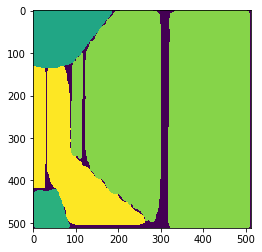

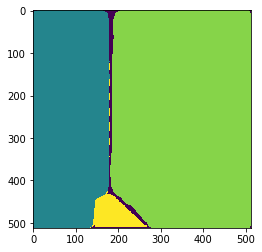

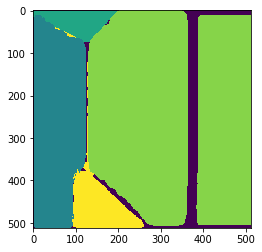

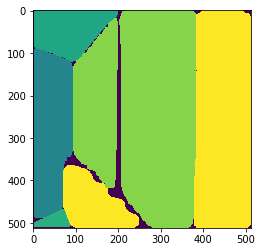

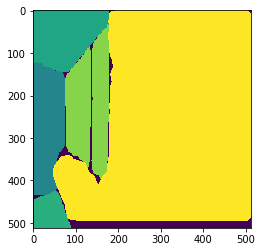

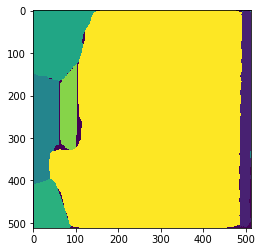

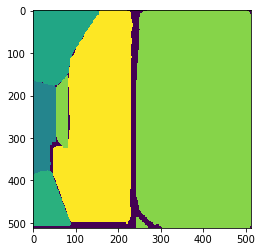

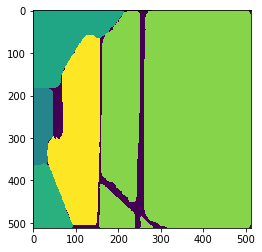

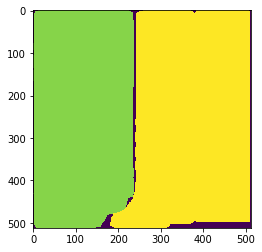

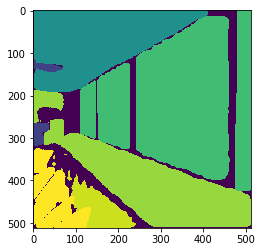

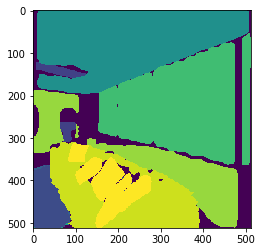

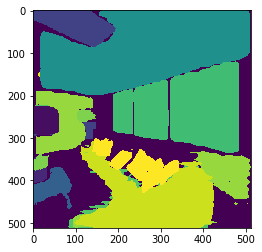

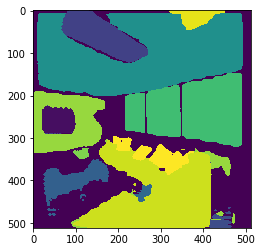

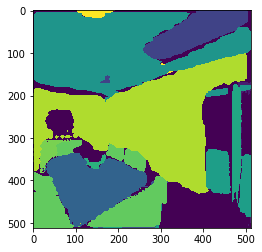

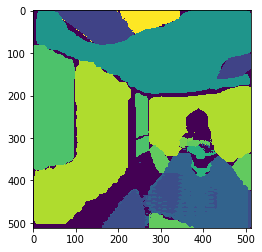

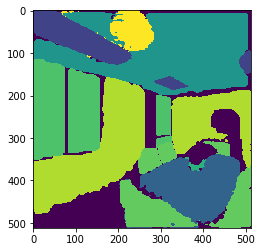

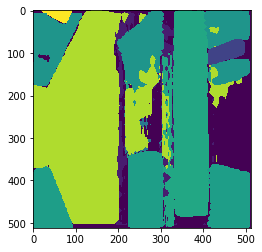

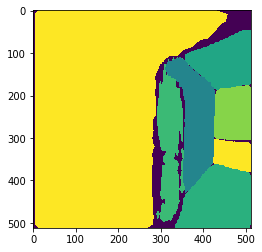

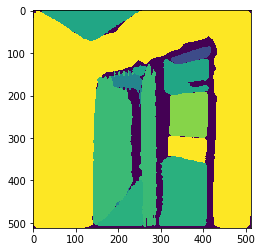

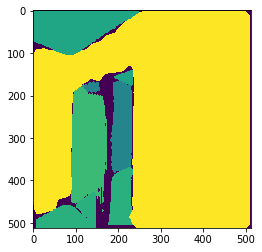

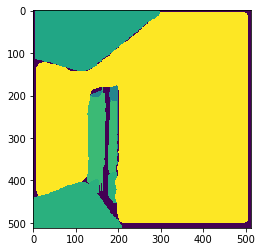

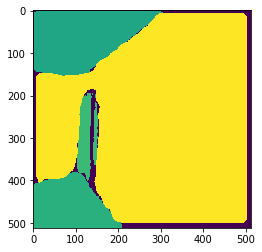

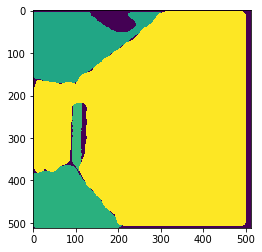

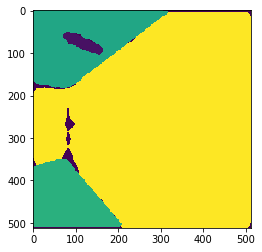

In [106]:
from examples.instance_segmentation.common import InstanceVisualizer

visualizer = InstanceVisualizer(model, dataloader_train, device=device, num_classes=num_classes)
visuals = visualizer.visualize_instance_segmentation_output(max_num_outputs=12)
# Visualize the output
for idx in visuals.keys():
    vis = visuals[idx]
    #values = np.unique(vis.ravel())
    im = plt.imshow(vis)
    # colors = [im.cmap(im.norm(value)) for value in values]
    # patches = [patches.Patch(color=colors[i], label=dataset_train.sem_id_to_name[value]) for i, value in enumerate(values)]
    # # put those patched as legend-handles into the legend
    # plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )
    plt.show()

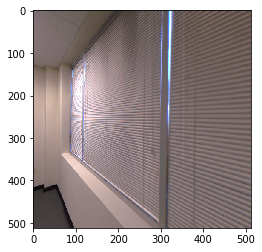

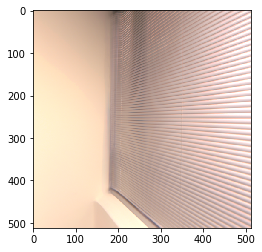

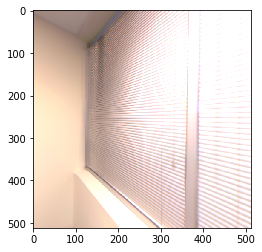

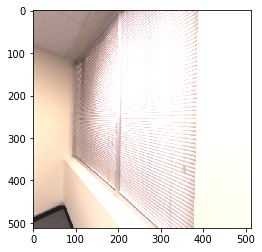

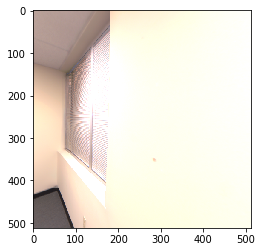

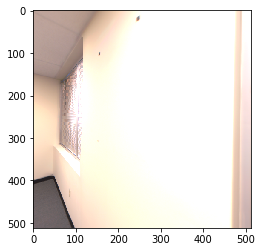

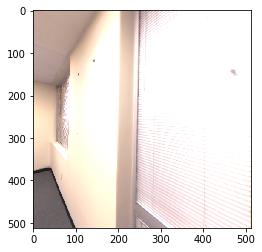

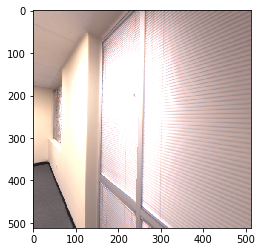

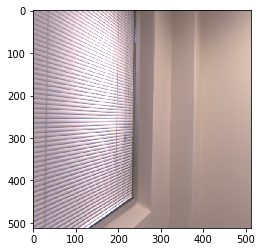

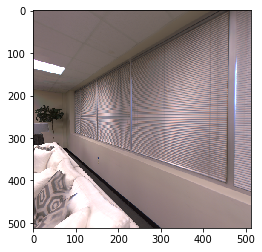

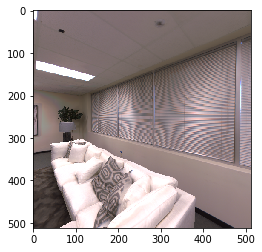

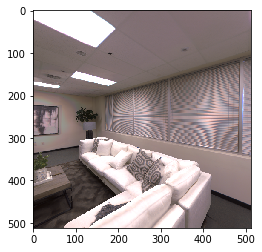

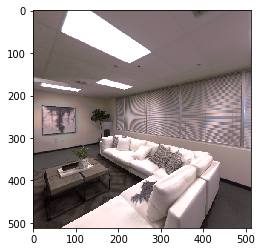

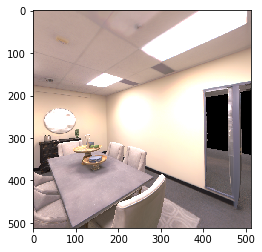

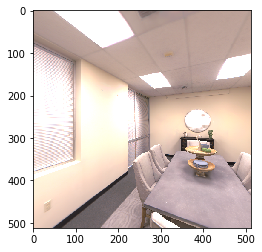

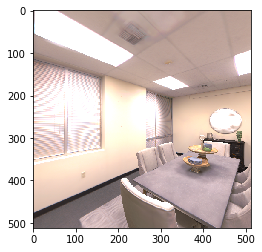

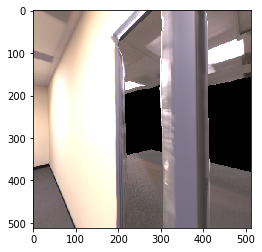

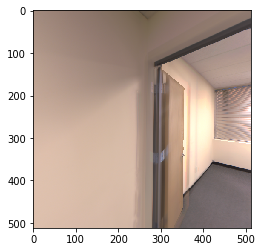

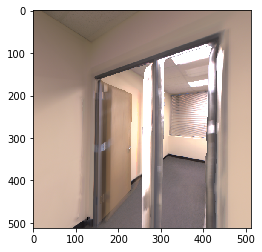

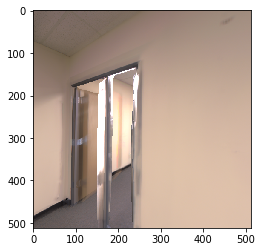

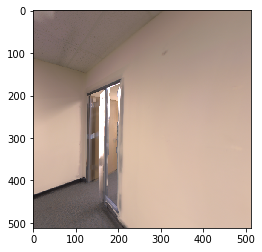

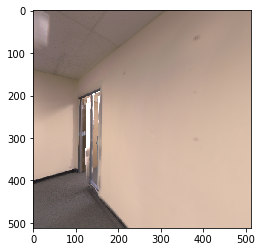

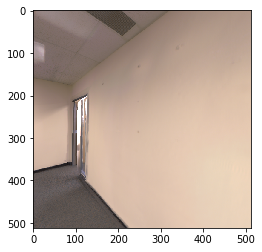

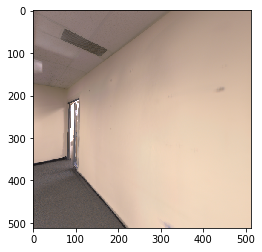

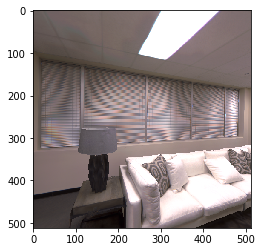

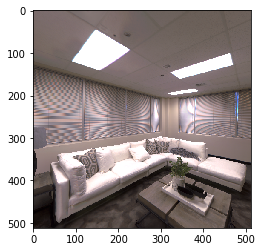

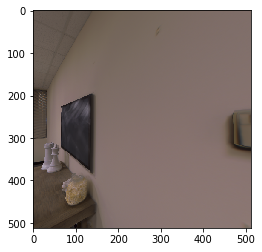

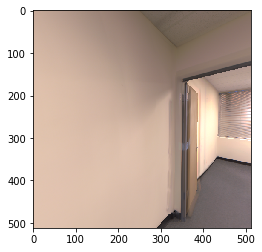

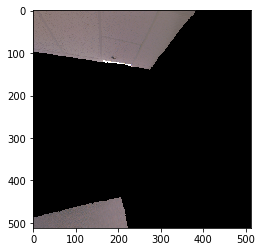

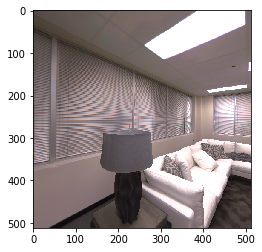

ValueError: not enough values to unpack (expected 2, got 1)

In [67]:
for img, target in dataloader_train:
    img1, img2 = img
    img1 = img1.permute(1, 2, 0).numpy()
    img2 = img2.permute(1, 2, 0).numpy()
    plt.imshow(img1)
    plt.show()
    plt.imshow(img2)
    plt.show()